In [2]:
import os
import numpy as np
import skimage.io as skio
from itertools import product
%matplotlib inline

Считаем какую-нибудь тестовую картинку.

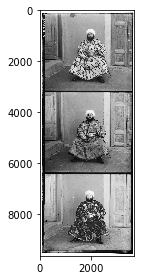

In [2]:
fimg = 'public_data/19_input/img.png'
img  = skio.imread(fimg, plugin='matplotlib')
skio.imshow(img)

Разрежем картинку на 3 части для каждого из каналов и отрежем по $5\%$ с каждой стороны, чтобы обрезать рамки пленки.

In [3]:
def divide_image(image, divisions=3):
    n, m = image.shape
    step = n // divisions
    width_margin = m // 100 * 5
    height_margin = n // 300 * 5
    for i in range(divisions):
        yield image[i*step + height_margin: (i+1)*step - height_margin, width_margin:-width_margin]

Напишем несколько вспомогательных функций, они понадобятся в будущем. Одна из них **rectangles_intersection** будет отвечать за пересечение произвольного числа прямоугольников заданных левым верхним и правым нижним углом. **rescale_channel** отвечает за уменьшение изображения вдвое. Просто будем брать каждый второй пиксель. Получается грубо, но этого достаточно для нахождения оптимального смещения. И последняя **mse** это наша метрика.  

In [4]:
def rectangles_intersection(starts, finishes):
    start = (np.max([x[0] for x in starts]), np.max([y[1] for y in starts]))
    finish = (np.min([x[0] for x in finishes]), np.min([y[1] for y in finishes]))
    return start, finish

def rescale_channel(image):
    return image[::2, ::2]

def mse(i1, i2):
    assert i1.shape == i2.shape
    return ((i1 - i2) ** 2).mean(axis=None)

Теперь функции непосредственно относящиеся к алгоритму. **shift** отвечает за смещение картинки *i2* на $(dx, dy)$ относительно *i1* и возвращает область пересечения для каждой из картинок.
**find_best_shift_for_two** находит оптимальный сдвиг картинки *i2* относительно *i1* итеративно перебирая сдвиги по $x$ и по $y$ и выбираю оптимальный сдвиг по метрике **mse**. Для совмещения трех картинок в функции **find_best_shift_for_three** будем находить сдвиг двух картинок относительно одной, а потом находить пересечение полученных областей. **pyramid_method** соответствует своему названию. Находит смещение для картинок меньшего размера, а затем ищет новый сдвиг в области $\pm2$ пикселей от оптиального сдвига на предыдущей итерации.

In [5]:
def shift(i1, i2, dx, dy):
    i1_shape, i2_shape = i1.shape, i2.shape
    start, finish = rectangles_intersection(((0, 0), (dx, dy)), (i1_shape, (dx + i2_shape[0], dy + i2_shape[1])))
    return i1[start[0]:finish[0], start[1]:finish[1]], i2[start[0] - dx:finish[0] - dx, start[1] - dy:finish[1] - dy]

def find_best_shift_for_two(i1, i2, dx_range, dy_range):
    best_shift = (0, 0)
    minimal_mse = np.infty
    for dx, dy in product(range(*dx_range), range(*dy_range)):
        i1_shifted, i2_shifted = shift(i1, i2, dx, dy)
        cur_shift_mse = mse(i1_shifted, i2_shifted)
        if minimal_mse > cur_shift_mse:
            minimal_mse = cur_shift_mse
            best_shift = (dx, dy)

    return best_shift

def find_best_shift_for_three(r, g, b, r_dx_range=(-15, 16), r_dy_range=(-15, 16), b_dx_range=(-15, 16),
                              b_dy_range=(-15, 16)):
    shape = r.shape
    best_shift_for_red = find_best_shift_for_two(g, r, r_dx_range, r_dy_range)
    best_shift_for_blue = find_best_shift_for_two(g, b, b_dx_range, b_dy_range)
    start, finish = rectangles_intersection(
        starts=(
            (0, 0), best_shift_for_red, best_shift_for_blue
        ),
        finishes=(
            shape,
            (best_shift_for_red[0] + shape[0], best_shift_for_red[1] + shape[1]),
            (best_shift_for_blue[0] + shape[0], best_shift_for_blue[1] + shape[1]),
        )
    )
    return (
        np.dstack((
            r[start[0] - best_shift_for_red[0]:finish[0] - best_shift_for_red[0],
            start[1] - best_shift_for_red[1]:finish[1] - best_shift_for_red[1]],
            g[start[0]:finish[0], start[1]:finish[1]],
            b[start[0] - best_shift_for_blue[0]:finish[0] - best_shift_for_blue[0],
            start[1] - best_shift_for_blue[1]:finish[1] - best_shift_for_blue[1]],
        )),
        best_shift_for_red,
        best_shift_for_blue,
    )

def pyramid_method(r, g, b):
    if r.shape[0] > 500 or r.shape[1] > 500:
        _, r_shift, b_shift = pyramid_method(rescale_channel(r), rescale_channel(g), rescale_channel(b))
        return find_best_shift_for_three(
            r, g, b,
            r_dx_range=(r_shift[0] * 2 - 2, r_shift[0] * 2 + 2),
            r_dy_range=(r_shift[1] * 2 - 2, r_shift[1] * 2 + 2),
            b_dx_range=(b_shift[0] * 2 - 2, b_shift[0] * 2 + 2),
            b_dy_range=(b_shift[1] * 2 - 2, b_shift[1] * 2 + 2),
        )
    return find_best_shift_for_three(r, g, b)

Следующая функция $-$ требуемая в условии задания, использует все методы описанные выше и сама по себе тривиальна.

In [6]:
def align(image, g_coord):
    b, g, r = tuple(divide_image(image))
    width_margin = image.shape[1] // 100 * 5
    height_margin = image.shape[0] // 300 * 5
    relative_coord = (g_coord[0] - b.shape[0] - 3 * height_margin, g_coord[1] - width_margin)
    colored, r_shift, b_shift = pyramid_method(r, g, b)
    red = (relative_coord[0] - r_shift[0] + b.shape[0] * 2 + 5 * height_margin, relative_coord[1] - r_shift[1] + width_margin)
    blue = (relative_coord[0] + height_margin - b_shift[0], relative_coord[1] - b_shift[1] + width_margin)
    return colored, blue, red

(1340, 224) (7652, 183)


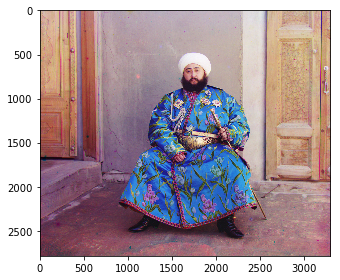

In [7]:
colored, b_coord, r_coord = align(img, (4500, 200))
print(b_coord, r_coord)
skio.imshow(colored)

In [18]:
r = skio.imread('valera.jpg', plugin='matplotlib')
g = skio.imread('valera.jpg', plugin='matplotlib')
b = skio.imread('valera.jpg', plugin='matplotlib')
# skio.imshow(np.dstack((r, g, b)))
skio.imread()

array([[[75, 75, 75],
        [57, 57, 57],
        [62, 62, 62],
        ..., 
        [68, 68, 68],
        [69, 69, 69],
        [71, 71, 71]],

       [[75, 75, 75],
        [56, 56, 56],
        [61, 61, 61],
        ..., 
        [69, 69, 69],
        [70, 70, 70],
        [71, 71, 71]],

       [[76, 76, 76],
        [55, 55, 55],
        [60, 60, 60],
        ..., 
        [71, 71, 71],
        [72, 72, 72],
        [71, 71, 71]],

       ..., 
       [[77, 77, 77],
        [46, 46, 46],
        [47, 47, 47],
        ..., 
        [17, 17, 17],
        [19, 19, 19],
        [20, 20, 20]],

       [[77, 77, 77],
        [47, 47, 47],
        [50, 50, 50],
        ..., 
        [17, 17, 17],
        [18, 18, 18],
        [19, 19, 19]],

       [[78, 78, 78],
        [49, 49, 49],
        [53, 53, 53],
        ..., 
        [17, 17, 17],
        [17, 17, 17],
        [17, 17, 17]]], dtype=uint8)

Результат работы выше. Получилось неплохо!